# Exploring the JIT

In [2]:
function do_work(n::Int)
    out = 0
    for i=1:n
        for j=1:n
            if j>i
                out += j-i
            end
        end
    end
    return out
end

do_work (generic function with 1 method)

In [3]:
# try it
@time do_work(1000)

  0.024920 seconds (2.90 k allocations: 130.314 KB)


166666500

In [4]:
# execution is faster the second time
@time do_work(1000)

  0.001824 seconds (5 allocations: 176 bytes)


166666500

# Introspection

In [5]:
code_typed(do_work)

1-element Array{Any,1}:
 LambdaInfo for do_work(::Int64)

In [6]:
code_llvm(do_work, (Int,))


define i64 @julia_do_work_71279(i64) #0 {
top:
  %1 = icmp slt i64 %0, 1
  br i1 %1, label %L5, label %if.lr.ph

if.lr.ph:                                         ; preds = %top
  %2 = add i64 %0, 1
  br label %if

L.loopexit:                                       ; preds = %L2
  %3 = add i64 %"#temp#.010", 1
  %4 = icmp eq i64 %3, %2
  br i1 %4, label %L5.loopexit, label %if

L2:                                               ; preds = %L2.outer, %if6
  %"#temp#1.0" = phi i64 [ %6, %if6 ], [ %"#temp#1.0.ph", %L2.outer ]
  %5 = icmp eq i64 %"#temp#1.0", %2
  br i1 %5, label %L.loopexit, label %if6

L5.loopexit:                                      ; preds = %L.loopexit
  br label %L5

L5:                                               ; preds = %L5.loopexit, %top
  %out.0.lcssa = phi i64 [ 0, %top ], [ %out.1.ph, %L5.loopexit ]
  ret i64 %out.0.lcssa

if:                                               ; preds = %if.lr.ph, %L.loopexit
  %out.011 = phi i64 [ 0, %if.lr.ph ], [ %out.1.ph, %L

In [7]:
code_native(do_work, (Int,))

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[2]
	pushq	%rbp
	movq	%rsp, %rbp
	xorl	%eax, %eax
Source line: 3
	testq	%rdi, %rdi
	jle	L96
	leaq	1(%rdi), %r9
	movl	$1, %r8d
	xorl	%esi, %esi
	xorl	%eax, %eax
	movl	$1, %edx
Source line: 4
	leaq	-1(%r8), %rcx
	jmp	L64
Source line: 6
L36:
	leaq	(%rax,%rsi), %rax
	leaq	-1(%rcx,%rax), %rax
	incq	%rcx
Source line: 4
	decq	%rcx
	nopw	%cs:(%rax,%rax)
L64:
	cmpq	%rcx, %rdi
	je	L79
Source line: 5
	incq	%rcx
	cmpq	%rdx, %rcx
	jle	L64
	jmp	L36
Source line: 3
L79:
	incq	%rdx
	decq	%rsi
	cmpq	%r9, %rdx
	je	L96
Source line: 4
	leaq	-1(%r8), %rcx
	jmp	L64
Source line: 10
L96:
	popq	%rbp
	retq
	nopw	%cs:(%rax,%rax)


# Using the Package Manager

In [8]:
Pkg.update()

INFO: Updating METADATA...
INFO: Updating FullRankModels master...
INFO: Updating DataArrays master...
INFO: Updating DataFrames master...
INFO: Computing changes...
INFO: No packages to install, update or remove


In [9]:
Pkg.add("ScikitLearn")

INFO: Nothing to be done


In [10]:
using ScikitLearn

# Calling out from Julia

## calling out to C
(thanks to http://www.exegetic.biz/blog/2015/09/monthofjulia-day-25-other-languages/)

In [11]:
# square root
# specify ((func-to-call, library), output-type, input-type(s), arguments)
ccall((:sqrt, "libm"), Float64, (Float64,), 64.0)

8.0

In [12]:
# write a "wrapper" in one line
csqrt(x::Float64) = ccall((:sqrt, "libm"), Float64, (Float64,), x)

csqrt (generic function with 1 method)

In [13]:
# above method will just work for scalars
# add a vectorized method with a macro
@vectorize_1arg Float64 csqrt

csqrt (generic function with 2 methods)

In [14]:
csqrt(rand(10))

10-element Array{Float64,1}:
 0.633343
 0.793032
 0.423646
 0.330446
 0.219082
 0.72601 
 0.944481
 0.845344
 0.298229
 0.52838 

## Calling out to Python

In [15]:
using PyCall

In [16]:
pyeval("2+2")

4

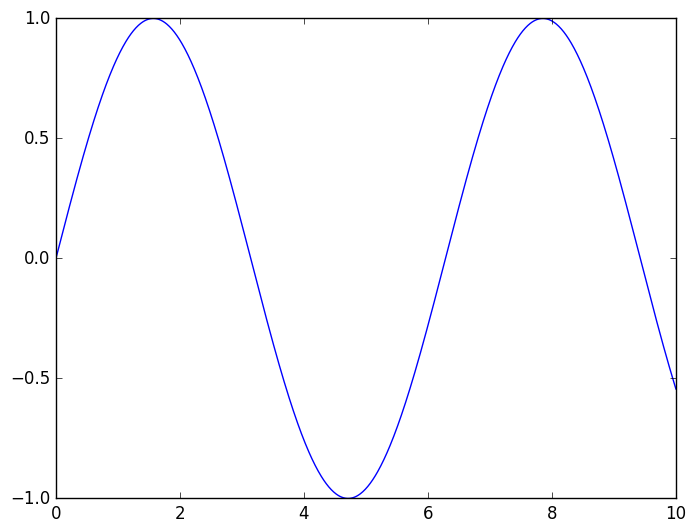

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32101c4d0>

In [17]:
using PyPlot
x = 0:.01:10
plot(x, sin(x))